# **Лабораторная работа 4.**

ФИО: Федоров Данила Вячеславович

Группа: БИВТ-20-3

Вариант: 25

Датасет: keremberke/chest-xray-classification

Датасет состоит из снимков грудной клетки человека и различается на 2 классификации:

*   NORMAL
*   PHEUMONIA

Задача заключается в создании нейросети, которая на основе изображения легкого человека сможет отличить здоровые легкие от нездоровых. При создании итовой модели будут участвовать моя собственная нейросеть, обученная на train_dataset и предобученная модель нейросети ResNet-18. Обучение будет проходить в 10 эпох и по итогу каждой эпохи будет выведен параметр Loss. Если он будет уменьшаться, значит нейросеть постепенно учится на своих ошибках.

Метрики датасета находятся ниже в коде.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torchvision
from torchvision import datasets, transforms

Подключение cuda для более быстрой работы программы

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Вы используете {device}")

Вы используете cuda


Загрузка датасета из веб-приложения Kaggle и распаковка в локальную папку google colab

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

In [ ]:
folder_path = './chest_xray'

if os.path.isdir(folder_path):
    print("Исходная папка выбрана верно")
else:
    print("Такой папки нет")

Исходная папка выбрана верно


**Шаг 1. Оформление датасета:** 

*   Нормализация данных (изображения теперь 200 х 200 пикселей)

*   Разделение датасета на тестовую выборку и тренировочную

*   Создание train_loader и test_loader для более удобной и быстрой работы






In [ ]:
transform = transforms.Compose([
    transforms.Resize((200, 200)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

train_dataset = datasets.ImageFolder(
    root=folder_path + '/train',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=folder_path + '/test',
    transform=transform
)

batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Количество изображений в тренировочном датасете {len(train_dataset)}")
print(f"Количество изображений в датасете для тестов {len(test_dataset)}")


Количество изображений в тренировочном датасете 5232
Количество изображений в датасете для тестов 624


**Шаг 2. Визуализация данных из датасета**

Вывод рандомных изображений из датасета и описание, к какому классу они относятся

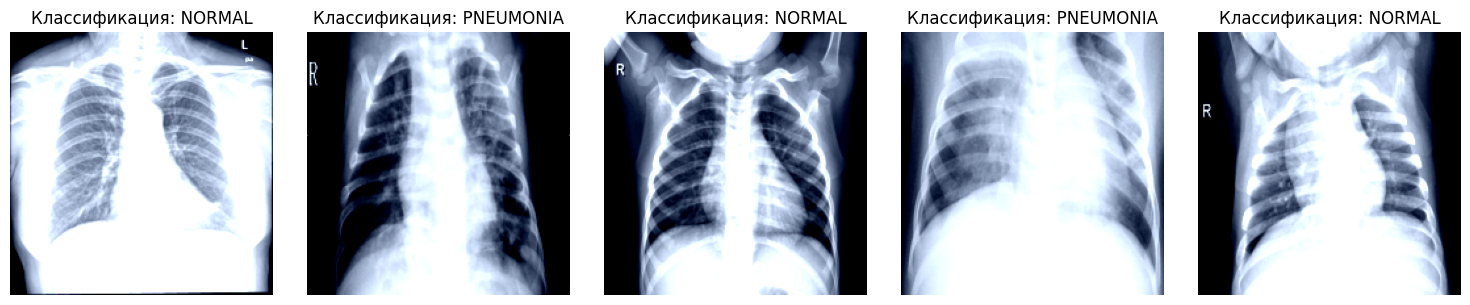

In [ ]:
def show_images(dataset, num_examples=5):
    class_indices = dataset.class_to_idx 
    class_names = list(class_indices.keys())
    
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

    for i, ax in enumerate(axes):
        class_name = np.random.choice(class_names) 
        class_index = class_indices[class_name] 

        image_index = np.random.randint(len(dataset.targets))
        while dataset.targets[image_index] != class_index:
            image_index = np.random.randint(len(dataset.targets))
        
        image, label = dataset[image_index]

        image = np.clip(image.permute(1, 2, 0).numpy() * 0.5 + 0.5, 0, 1)

        ax.imshow(image)
        ax.set_title(f"Классификация: {class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_dataset)

**Шаг 3. Создание и обучение своей нейросети**

In [ ]:
import torch.nn as nn

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(3 * 200 * 200, 100)
        self.fc2 = nn.Linear(100, 70)
        self.fc3 = nn.Linear(70, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"{epoch+1} Поколение обучения завершено, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

In [ ]:
num_epochs = 10

In [ ]:
model = NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

train_accuracy = evaluate_model(model, train_loader)
test_accuracy = evaluate_model(model, test_loader)

print(f"Точность на train_dataset: {train_accuracy}")
print(f"Точность на test_dataset: {test_accuracy}")

1 Поколение обучения завершено, Loss: 0.2143215309010773
2 Поколение обучения завершено, Loss: 0.11089489111540521
3 Поколение обучения завершено, Loss: 0.12033098579452532
4 Поколение обучения завершено, Loss: 0.09680736135327961
5 Поколение обучения завершено, Loss: 0.08090737696010165
6 Поколение обучения завершено, Loss: 0.07426034997603516
7 Поколение обучения завершено, Loss: 0.07398209935508487
8 Поколение обучения завершено, Loss: 0.062321306904777884
9 Поколение обучения завершено, Loss: 0.05553134509203274
10 Поколение обучения завершено, Loss: 0.053614603730327476
Точность на train_dataset: 0.9831804281345565
Точность на test_dataset: 0.8830128205128205


**Шаг 4. Использование TransferLearning и вывод точности работы нейросети**

In [ ]:
pretrained_model = resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 15)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
train_model(pretrained_model, train_loader, criterion, optimizer, num_epochs, device)
accuracy = evaluate_model(pretrained_model, test_loader)
print(f"Итоговая точность нейросети (с использованием ResNet-18) = {accuracy}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


1 Поколение обучения завершено, Loss: 0.32825020709779207
2 Поколение обучения завершено, Loss: 0.0533950178906685
3 Поколение обучения завершено, Loss: 0.029354271018968488
4 Поколение обучения завершено, Loss: 0.019427062205334262
5 Поколение обучения завершено, Loss: 0.012999567274208658
6 Поколение обучения завершено, Loss: 0.009566812734857837
7 Поколение обучения завершено, Loss: 0.006398094322521058
8 Поколение обучения завершено, Loss: 0.004947077360844649
9 Поколение обучения завершено, Loss: 0.004350047909211731
10 Поколение обучения завершено, Loss: 0.004957250486235929
Итоговая точность нейросети (с использованием ResNet-18) = 0.8910256410256411
